# Importing Library

In [4]:
pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from keras_tuner import RandomSearch, BayesianOptimization, Hyperband
import xgboost as xgb
import time
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from keras import models, layers, optimizers, regularizers, callbacks
from keras.utils import model_to_dot
from IPython.display import SVG

import warnings
warnings.filterwarnings('ignore')

# Data Cleaning and Pre-processing

## Loading dataset and remove unnecessary columns

In [7]:
listingsOG = pd.read_csv('/content/drive/MyDrive/Colab Data/listings_NY.csv')

In [8]:
Columns_to_remove = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name','description', 'neighborhood_overview',
                     'picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
                     'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_thumbnail_url',
                     'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_verifications',
                     'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
                     'neighbourhood_cleansed', 'latitude', 'longitude', 'bathrooms_text', 'minimum_nights', 'maximum_nights',
                     'minimum_minimum_nights','maximum_minimum_nights', 'minimum_maximum_nights',
                     'maximum_maximum_nights','minimum_nights_avg_ntm', 'property_type',
                     'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability','availability_30', 'availability_60',
                     'availability_90', 'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
                     'first_review', 'last_review', 'license', 'calculated_host_listings_count',
                     'review_scores_rating',
                     'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
                     'calculated_host_listings_count_shared_rooms']

In [9]:
listings = listingsOG.drop(Columns_to_remove, axis=1)
listings.isnull().sum()

,0
host_acceptance_rate,14311
host_is_superhost,429
host_total_listings_count,5
neighbourhood_group_cleansed,0
room_type,0
accommodates,0
bathrooms,14751
bedrooms,5841
beds,14886
amenities,0


## Removing null values

In [ ]:
listings = listings.dropna(subset = 'price' , axis=0)
listings = listings.dropna(subset = 'reviews_per_month' , axis=0)
listings = listings.dropna(subset = 'host_acceptance_rate' , axis=0)
listings = listings.dropna(subset = 'beds' , axis=0)
listings = listings.dropna(subset = 'bedrooms' , axis=0)
listings = listings.dropna(subset = 'bathrooms' , axis=0)
listings = listings.dropna(subset = 'host_is_superhost' , axis=0)
listings = listings.dropna(subset = 'review_scores_location' , axis=0)
listings.isnull().sum()

## Removing Outliers

{'whiskers': [<matplotlib.lines.Line2D at 0x7ee699165c30>,
 'caps': [<matplotlib.lines.Line2D at 0x7ee6991654b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ee699166140>],
 'medians': [<matplotlib.lines.Line2D at 0x7ee699166050>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ee699165ba0>],
 'means': []}

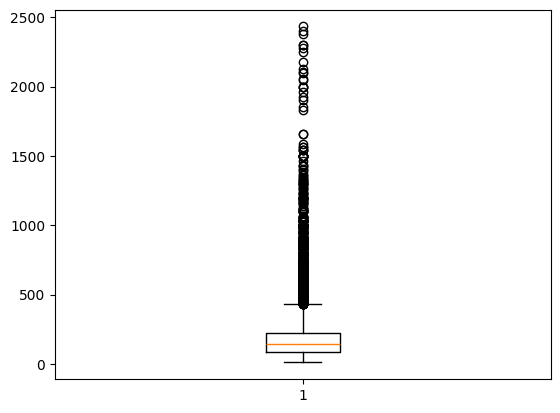

In [11]:
listings['price'] = listings['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
listings = listings[listings['price'] < 2500]
plt.boxplot(listings['price'])

## Features Engineering

In [12]:
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].replace({'\%': ''}, regex=True).astype(float)
listings['host_acceptance_rate'] = listings['host_acceptance_rate'] / 100
listings['host_is_superhost'] = listings['host_is_superhost'].replace({'t': 1, 'f': 0})
listings['instant_bookable'] = listings['instant_bookable'].replace({'t': 1, 'f': 0})
listings['total_amenities'] = listings['amenities'].str.split(",").str.len()
listings['amenities'] = listings['amenities'].str[1:-1]
listings = pd.get_dummies(listings, columns=['neighbourhood_group_cleansed'], prefix = '', prefix_sep='', dtype=int)
listings['room_type'] = listings['room_type'].replace({'Shared room': 0, 'Hotel room': 1, 'Private room': 2, 'Entire home/apt': 3})

In [13]:
listings['Has_TV'] = [1 if "TV" in x else 0 for x in listings['amenities']]
listings['Has_Washer'] = [1 if "Washer" in x else 0 for x in listings['amenities']]
listings['Has_Dryer'] = [1 if "Dryer" in x else 0 for x in listings['amenities']]
listings['Has_Elevator'] = [1 if "Elevator" in x else 0 for x in listings['amenities']]
listings['Has_Gym'] = [1 if "Gym" in x else 0 for x in listings['amenities']]
listings['Has_Cable'] = [1 if "TV with standard cable" in x else 0 for x in listings['amenities']]
listings['Has_Pets'] = [1 if "Pets allowed" in x else 0 for x in listings['amenities']]
listings['Has_Pool'] = [1 if "Pool" in x else 0 for x in listings['amenities']]
listings['Has_Breakfast'] = [1 if "Breakfast" in x else 0 for x in listings['amenities']]
listings['Has_Coffee'] = [1 if "Coffee" in x else 0 for x in listings['amenities']]
listings['Host_greets_you'] = [1 if "Host greets you" in x else 0 for x in listings['amenities']]
listings['Has_Kitchen'] = [1 if "Kitchen" in x else 0 for x in listings['amenities']]
listings['Has_Heating'] = [1 if "Heating" in x else 0 for x in listings['amenities']]
listings['Has_Microwave'] = [1 if "Microwave" in x else 0 for x in listings['amenities']]
listings['Has_AC'] = [1 if "Air conditioning" in x else 0 for x in listings['amenities']]

In [14]:
listings = listings.drop(['amenities'], axis=1)

## Correlation Matrix

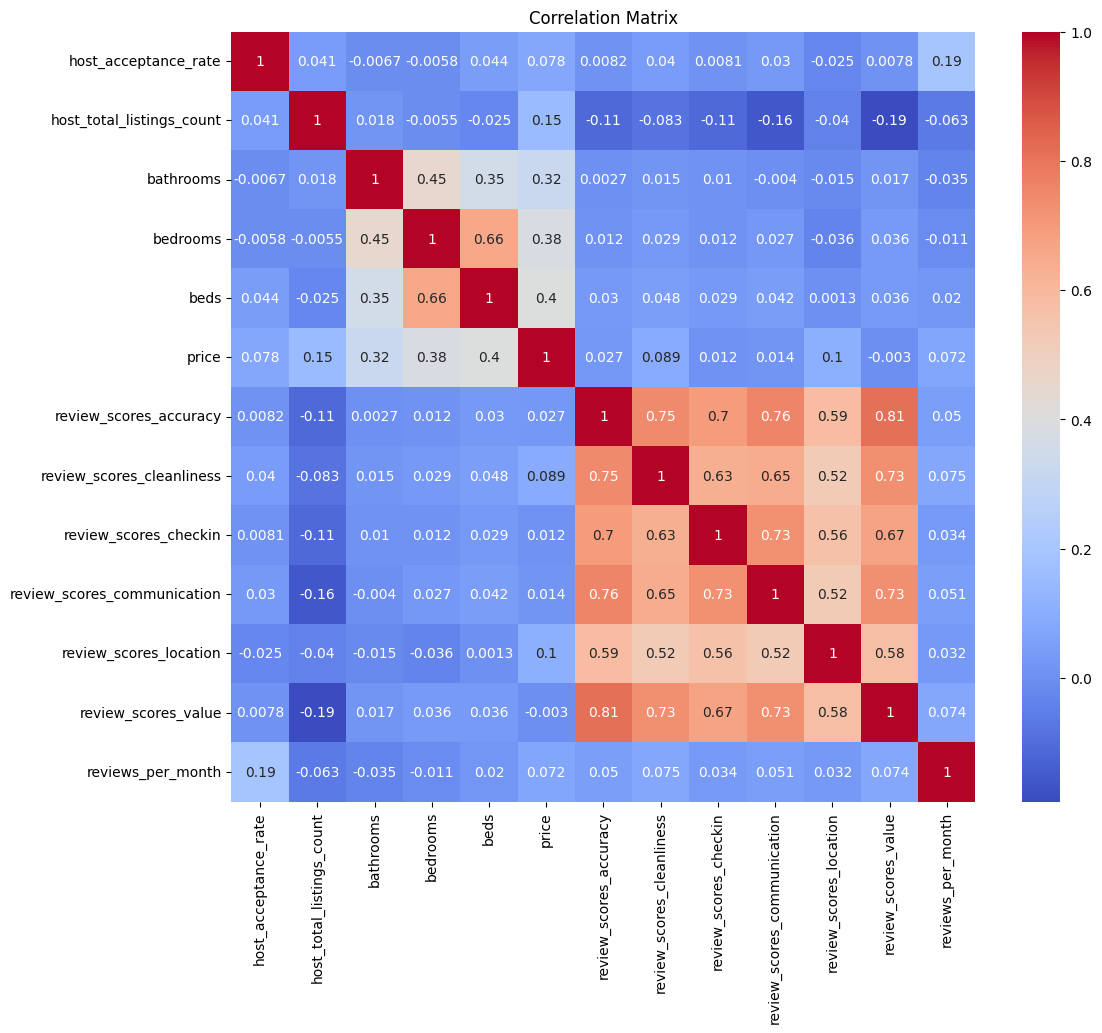

In [16]:
numeric_df = listings.select_dtypes(include='float')
corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Modeling with non-log transformed target variable

## Data splitting


In [144]:
# Without log-transform
X = listings.drop('price', axis=1)
y = listings['price']

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=69)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=69)

In [161]:
# With log-transform
X = listings.drop('price', axis=1)
y = np.log(listings['price'])

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=69)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=69)

## Linear Models

### Linear Regression

In [85]:
lr = LinearRegression()
lr.fit(X_train, y_train)
np.set_printoptions(precision=4, suppress=True)
print('Estimated coefficient: ' + str(lr.coef_))
print('Estimated intercept: ' + str(lr.intercept_))

Estimated coefficient: [ 1.4104e+00  1.1540e+01  1.2818e+01  1.5734e+01  5.3941e+01  2.8722e+01
  2.4786e+01  1.2771e+00  1.5358e+00 -1.5000e+00  1.9676e+01 -6.1471e+00
  2.9535e+00  1.0248e+01 -1.2645e+01  1.2015e+01  6.2702e+00  1.7571e+01
 -9.9074e+13 -2.3689e+14 -2.4138e+14 -1.8439e+14 -6.1333e+13  3.2891e+00
  3.8665e+00 -4.1443e+00  1.6406e+01  1.5674e+01  1.6038e+00  2.5838e+00
  6.7528e+00  2.7210e+00  6.7795e+00 -1.0836e+00 -1.6556e+01 -1.6740e+00
 -1.4775e+01  4.6690e+00]
Estimated intercept: 191.35540044137107


In [90]:
print('Training score:', lr.score(X_train, y_train))
print('Test score:', lr.score(X_test, y_test))

Training score: 0.45579610534620807
Test score: 0.45738265561780667


In [95]:
# MSE for non-log transformed
lr_pred_train = lr.predict(X_train)
print(round(mean_squared_error(y_train, lr_pred_train),4))

lr_pred_test = lr.predict(X_test)
print(round(mean_squared_error(y_test, lr_pred_test),4))

18556.4422
21011.1652


In [ ]:
# MSE for log transformed
lr_pred_train = lr.predict(X_train)
print(round(mean_squared_error(np.exp(y_train), np.exp(lr_pred_train)),4))

lr_pred_test = lr.predict(X_test)
print(round(mean_squared_error(np.exp(y_test), np.exp(lr_pred_test)),4))

### Ridge Regression with GridSearch



In [81]:
base_ridge = Ridge(random_state = 69)
param_ridge = {'alpha': [0.01, 0.1, 1, 10, 100, 1000]}

grid_ridge = GridSearchCV(base_ridge, param_ridge, cv=5)
grid_ridge.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(random_state=69),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100, 1000]})

In [97]:
print('Hyperparameter chosen: ' + str(grid_ridge.best_params_))
print('Mean of validation score: ' + str(grid_ridge.best_score_))
print('Training score: ' + str(grid_ridge.score(X_train, y_train)))
print('Test score: ' + str(grid_ridge.score(X_test, y_test)))

Hyperparameter chosen: {'alpha': 100}
Mean of validation score: 0.44423303190250846
Training score: 0.4557537055241456
Test score: 0.45683897279531005


In [112]:
# MSE for non-log transformed
ridge_pred_train = grid_ridge.predict(X_train)
print(round(mean_squared_error(y_train, ridge_pred_train),4))

ridge_pred_test = grid_ridge.predict(X_test)
print(round(mean_squared_error(y_test, ridge_pred_test),4))

18557.888
21032.2177


In [ ]:
# MSE for log transformed
ridge_pred_train = lr.predict(X_train)
print(round(mean_squared_error(np.exp(y_train), np.exp(ridge_pred_train)),4))

ridge_pred_test = lr.predict(X_test)
print(round(mean_squared_error(np.exp(y_test), np.exp(ridge_pred_test)),4))

### Lasso Regression with GridSearch

In [168]:
base_lasso = Lasso(random_state = 69)
param_lasso = {'alpha' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}
grid_lasso = GridSearchCV(base_lasso, param_lasso, cv=5)
grid_lasso.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(random_state=69),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]})

In [169]:
print(grid_lasso.best_params_ )
print(grid_lasso.best_score_ )
print(round(grid_lasso.score(X_train, y_train), 4))
print(round(grid_lasso.score(X_test, y_test), 4))

{'alpha': 0.001}
0.5627686171885131
0.5673
0.5722


In [170]:
# MSE for non-log transformed or before backtransform
lasso_pred_train = grid_lasso.predict(X_train)
print(round(mean_squared_error(y_train, lasso_pred_train),4))

lasso_pred_test = grid_lasso.predict(X_test)
print(round(mean_squared_error(y_test, lasso_pred_test),4))

0.2336
0.226


In [171]:
# MSE for after backtransform
lasso_pred_train = grid_lasso.predict(X_train)
print(round(mean_squared_error(np.exp(y_train), np.exp(lasso_pred_train)),4))

lasso_pred_test = grid_lasso.predict(X_test)
print(round(mean_squared_error(np.exp(y_test), np.exp(lasso_pred_test)),4))

20309.7344
17672.8052


### Linear SVR with GridSearch

In [173]:
linear_svr = LinearSVR(random_state = 69)
params_svr = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_lrsvr = GridSearchCV(linear_svr, params_svr, cv = 5)
grid_lrsvr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LinearSVR(random_state=69),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

In [174]:
print('Best C chosen: ', grid_lrsvr.best_params_['C'])
print('Test accuracy under the best linear SVM model:', grid_lrsvr.score(X_test, y_test))
print('Mean validation accuracy for linear SVM:', grid_lrsvr.best_score_)

Best C chosen:  0.1
Test accuracy under the best linear SVM model: 0.5633679549257256
Mean validation accuracy for linear SVM: 0.5506958160740376


In [176]:
print(round(grid_lrsvr.score(X_train, y_train),4))
print(round(grid_lrsvr.score(X_test, y_test),4))

0.5554
0.5634


In [177]:
# # MSE for non-log transformed or before backtransform
svr_pred_train = grid_lrsvr.predict(X_train)
print(round(mean_squared_error(y_train, svr_pred_train),4))

svr_pred_test = grid_lrsvr.predict(X_test)
print(round(mean_squared_error(y_test, svr_pred_test),4))

0.24
0.2306


In [178]:
# MSE after backtransform
svr_pred_train = grid_lrsvr.predict(X_train)
print(round(mean_squared_error(np.exp(y_train), np.exp(svr_pred_train)),4))

svr_pred_test = grid_lrsvr.predict(X_test)
print(round(mean_squared_error(np.exp(y_test), np.exp(svr_pred_test)),4))

52624.5533
19777.7261


## Non-linear models

### Decision Tree Regressor with GridSearch

In [162]:
dt = DecisionTreeRegressor(random_state = 69)
dt_params = {'max_depth': range(1,11)}
grid_tree = GridSearchCV(dt, dt_params, cv=5)
grid_tree.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=69),
             param_grid={'max_depth': range(1, 11)})

In [183]:
print('Best max_depth chosen:', grid_tree.best_params_['max_depth'])
print('Test accuracy under the best decision tree model:', grid_tree.score(X_test, y_test))
print('Mean validation accuracy for decison tree:', grid_tree.best_score_)

Best max_depth chosen: 7
Test accuracy under the best decision tree model: 0.578183699476446
Mean validation accuracy for decison tree: 0.5629729725690025


In [184]:
print(grid_tree.score(X_train, y_train))
print(grid_tree.score(X_test, y_test))

0.640138342610644
0.578183699476446


In [185]:
# MSE for non-log transformed or before backtransform
dt_pred_train = grid_tree.predict(X_train)
print(round(mean_squared_error(y_train, dt_pred_train),4))

dt_pred_test = grid_tree.predict(X_test)
print(round(mean_squared_error(y_test, dt_pred_test),4))

0.1943
0.2228


In [186]:
# MSE after backtransform
dt_pred_train = grid_tree.predict(X_train)
print(round(mean_squared_error(np.exp(y_train), np.exp(dt_pred_train)),4))

dt_pred_test = grid_tree.predict(X_test)
print(round(mean_squared_error(np.exp(y_test), np.exp(dt_pred_test)),4))

15153.6308
16789.3403


### Random Forest Regressor with GridSearch

In [187]:
rnd_clf = RandomForestRegressor(random_state=69)
param_rnd = {"n_estimators": [200,300,500],
            "max_depth": [3,5,7],
            "max_samples": [100, 200, 300]
            }
grid_rnd = GridSearchCV(rnd_clf, param_rnd, cv = 5)
grid_rnd.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=69),
             param_grid={'max_depth': [3, 5, 7], 'max_samples': [100, 200, 300],
                         'n_estimators': [200, 300, 500]})

In [188]:
print('Best param: ', grid_rnd.best_params_)
print('Mean validation accuracy for random forest:', grid_rnd.best_score_)
print(round(grid_rnd.score(X_train, y_train_log), 4))
print(round(grid_rnd.score(X_test, y_test_log), 4))

Best param:  {'max_depth': 7, 'max_samples': 300, 'n_estimators': 500}
Mean validation accuracy for random forest: 0.5950766285181425
0.6122
0.6087


In [189]:
print(grid_rnd.score(X_train, y_train))
print(grid_rnd.score(X_test, y_test))

0.6121684019570927
0.6087478238256314


In [190]:
# MSE for non-log transformed or before backtransform
rnd_pred_train = grid_rnd.predict(X_train)
print(round(mean_squared_error(y_train, rnd_pred_train),4))

rnd_pred_test = grid_rnd.predict(X_test)
print(round(mean_squared_error(y_test, rnd_pred_test),4))

0.2094
0.2066


In [191]:
# MSE after backtransform
rnd_pred_train = grid_rnd.predict(X_train)
print(round(mean_squared_error(np.exp(y_train), np.exp(rnd_pred_train)),4))

rnd_pred_test = grid_rnd.predict(X_test)
print(round(mean_squared_error(np.exp(y_test), np.exp(rnd_pred_test)),4))

20590.1344
18371.5055


### XGBoost with GridSearch

In [43]:
param_xgb = {
    "gamma": [0.0001, 0.001, 0.01],
    "learning_rate": [0.001, 0.01, 0.1],
    "max_depth": [1, 3, 5]
    }

xgb_reg = xgb.XGBRegressor(n_estimators = 500, random_state=69)
grid_xgb = GridSearchCV(estimator=xgb_reg, param_grid=param_xgb, cv=5, scoring="neg_mean_squared_error")
grid_xgb.fit(X_train, y_train)

print("Best parameters:", grid_xgb.best_params_)
print("Best score:", grid_xgb.best_score_)

Best parameters: {'gamma': 0.0001, 'learning_rate': 0.1, 'max_depth': 5}
Best score: -12619.69403053174


In [ ]:
print("Training accuracy:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Testing accuracy:", round(r2_score(y_test, testing_preds_xgb_reg),4))

In [47]:
# MSE for non-log transform or before backtransform
best_model = grid_xgb.best_estimator_
training_preds_xgb_reg = best_model.predict(X_train)
testing_preds_xgb_reg = best_model.predict(X_test)
print(round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print(round(mean_squared_error(y_test, testing_preds_xgb_reg),4))

Training MSE: 2391.128
Validation MSE: 12102.7502
Training accuracy: 0.9311
Testing accuracy: 0.6049


In [ ]:
# MSE after backtransform
best_model = grid_xgb.best_estimator_
training_preds_xgb_reg = best_model.predict(X_train)
testing_preds_xgb_reg = best_model.predict(X_test)
print(round(mean_squared_error(np.exp(y_train), np.exp(rnd_pred_train)),4))
print(round(mean_squared_error(np.exp(y_test), np.exp(rnd_pred_test)),4))

20590.1344
18371.5055


In [ ]:
fig = plt.figure(figsize=(12,8))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
plt.subplots_adjust(top=0.93, wspace=0)

ax2.scatter(y_train, training_preds_xgb_reg, s=2, alpha=0.7)
ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax2.set_title('Train set')
ax2.set_xlabel('Actual values')
ax2.set_ylabel('')
ax2.set_yticklabels(labels='')

ax1.scatter(y_test, val_preds_xgb_reg, s=2, alpha=0.7)
ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax1.set_title('Test set')
ax1.set_xlabel('Actual values')
ax1.set_ylabel('Predicted values')

### Artificial Neural Network

Basic 3-layer ANN

In [49]:
ann = models.Sequential()
ann.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
ann.add(layers.Dense(256, activation='relu'))
ann.add(layers.Dense(256, activation='relu'))
ann.add(layers.Dense(1, activation='linear'))

ann.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

print(ann.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           4,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 104,065 (406.50 KB)

 Trainable params: 104,065 (406.50 KB)

 Non-trainable params: 0 (0.00 B)

None


In [50]:
ann_start = time.time()

ann_history = ann.fit(X_train,
                  y_train,
                  epochs=100,
                  batch_size=256,
                  validation_split = 0.1)

ann_end = time.time()

print(f"Time taken to run: {round((ann_end - ann_start)/60,1)} minutes")

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 66354.3281 - mean_squared_error: 66354.3281 - val_loss: 29757.2734 - val_mean_squared_error: 29757.2734
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 27195.9043 - mean_squared_error: 27195.9043 - val_loss: 22680.1816 - val_mean_squared_error: 22680.1816
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 17567.7812 - mean_squared_error: 17567.7812 - val_loss: 21815.7129 - val_mean_squared_error: 21815.7129
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 18920.4902 - mean_squared_error: 18920.4902 - val_loss: 21255.8750 - val_mean_squared_error: 21255.8750
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 16063.9746 - mean_squared_error: 16063.9746 - val_loss: 21323.7461 - val_mean_squared_error: 21323.7461
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 17177.8750 - mean_squared_error: 17177.8750 - val_loss: 20735.3867 - val_mean_squared_error: 20735.3867
Epoch 7/100
35/35 ━━━

In [51]:
def nn_model_evaluation(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))

In [52]:
nn_model_evaluation(ann)

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training MSE: 4628.6753
Validation MSE: 17594.4475

Training r2: 0.8667
Validation r2: 0.4256


ANN with 4 layers, L1 regularization, changed learning rate and early stopping

In [61]:
ann2 = models.Sequential()
ann2.add(layers.Dense(128, input_shape = (X_train.shape[1],), kernel_regularizer = regularizers.l1(0.0005), activation = 'relu'))
ann2.add(layers.Dense(256, kernel_regularizer = regularizers.l1(0.0005), activation = 'relu'))
ann2.add(layers.Dense(256, kernel_regularizer = regularizers.l1(0.0005), activation = 'relu'))
ann2.add(layers.Dense(512, kernel_regularizer = regularizers.l1(0.0005), activation = 'relu'))
ann2.add(layers.Dense(1, activation = 'linear'))

ann2.compile(loss = 'mean_squared_error',
            optimizer = Adam(learning_rate=0.001),
            metrics = ['mean_squared_error'])

print(ann2.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                     │ (None, 128)                 │           4,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 235,905 (921.50 KB)

 Trainable params: 235,905 (921.50 KB)

 Non-trainable params: 0 (0.00 B)

None


In [62]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True
)

In [63]:
ann2_history = ann2.fit(
                  X_train, y_train,
                  batch_size=256,
                  epochs=100,
                  validation_data=(X_val, y_val),
                  callbacks=[early_stopping]
                )

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 59865.8086 - mean_squared_error: 59859.8672 - val_loss: 24969.4492 - val_mean_squared_error: 24963.5332
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 18497.4707 - mean_squared_error: 18491.5801 - val_loss: 22650.1797 - val_mean_squared_error: 22644.3750
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 18727.8730 - mean_squared_error: 18722.0820 - val_loss: 21788.6836 - val_mean_squared_error: 21782.9219
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 18412.9375 - mean_squared_error: 18407.1895 - val_loss: 21977.3906 - val_mean_squared_error: 21971.6797
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 17877.9102 - mean_squared_error: 17872.1992 - val_loss: 20882.8203 - val_mean_squared_error: 20877.1309
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 16274.4033 - mean_squared_error: 16268.7080 - val_loss: 20362.7168 - val_mean_squared_error: 20357.0391
Epoch 7/100
39/3

In [64]:
nn_model_evaluation(ann2)

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training MSE: 9526.7524
Validation MSE: 14325.5991

Training r2: 0.7256
Validation r2: 0.5323


ANN with hyperparameters optimization (Random Search, Bayesian and Hyperband)

(Takes a long time, like at least 10 minutes for each method)

In [ ]:
def build_model(hp):
  ann3 = models.Sequential()
  ann3.add(layers.Dense(units=hp.Int('units_0', min_value=32, max_value=128, step=32),
                        input_shape = (X_train.shape[1],), kernel_regularizer = regularizers.l1(0.005),
                        activation =hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])))
  ann3.add(layers.Dense(units=hp.Int('units_1', min_value=32, max_value=256, step=32),
                    activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])))
  ann3.add(layers.Dense(units=hp.Int('units_2', min_value=32, max_value=256, step=32),
                    activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])))
  ann3.add(layers.Dense(1, activation = 'linear'))

  ann3.compile(loss = 'mean_squared_error',
              optimizer = Adam(hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
              metrics = ['mean_squared_error'])
  return ann3

def evaluate_model(ann3, X_test, y_test):
    test_loss = ann3.evaluate(X_test, y_test, verbose=0)[0]  # Return only test loss
    return test_loss

max_trials = 10
max_epochs = 50

In [ ]:
# Random Search with overwrite=True to force re-run
random_tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=max_trials,
    directory='random_search',
    project_name='airbnb',
    overwrite=True
)

start_time = time.time()
random_tuner.search(X_train, y_train, epochs=max_epochs, validation_data=(X_val, y_val), verbose=0)
random_search_time = time.time() - start_time

random_search_best_model = random_tuner.get_best_models(num_models=1)[0]
random_search_test_loss = evaluate_model(random_search_best_model, X_test, y_test)
random_search_best_hyperparameters = random_tuner.get_best_hyperparameters(num_trials=1)[0].values

In [ ]:
bayesian_tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=max_trials,
    directory='bayesian_opt',
    project_name='airbnb',
    overwrite=True
)

start_time = time.time()
bayesian_tuner.search(X_train, y_train, epochs=max_epochs, validation_data=(X_val, y_val), verbose=0)
bayesian_search_time = time.time() - start_time

bayesian_search_best_model = bayesian_tuner.get_best_models(num_models=1)[0]
bayesian_search_test_loss = evaluate_model(bayesian_search_best_model, X_test, y_test)
bayesian_search_best_hyperparameters = bayesian_tuner.get_best_hyperparameters(num_trials=1)[0].values

In [ ]:
# Hyperband with overwrite=True
hyperband_tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=max_epochs,
    directory='hyperband',
    project_name='airbnb',
    overwrite=True
)

start_time = time.time()
hyperband_tuner.search(X_train, y_train, validation_data=(X_val, y_val), verbose=0)
hyperband_search_time = time.time() - start_time

hyperband_search_best_model = hyperband_tuner.get_best_models(num_models=1)[0]
hyperband_search_test_loss = evaluate_model(hyperband_search_best_model, X_test, y_test)
hyperband_search_best_hyperparameters = hyperband_tuner.get_best_hyperparameters(num_trials=1)[0].values

In [ ]:
pd.set_option('display.max_colwidth', None)

results = {
    "Method": ["Random Search", "Bayesian Optimization", "Hyperband"],
    "Test Loss": [random_search_test_loss, bayesian_search_test_loss, hyperband_search_test_loss],
    "Time (seconds)": [random_search_time, bayesian_search_time, hyperband_search_time],
    "Best Hyperparameters": [
        random_search_best_hyperparameters,
        bayesian_search_best_hyperparameters,
        hyperband_search_best_hyperparameters
    ]
}


results_df = pd.DataFrame(results)
print(results_df)

In [ ]:
nn_model_evaluation(random_search_best_model)

In [ ]:
nn_model_evaluation(bayesian_search_best_model)

In [ ]:
nn_model_evaluation(hyperband_search_best_model)